In [58]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
from sklearn.cluster import KMeans
from pykalman import KalmanFilter 
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt          
%matplotlib inline

In [33]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

"""
https://poloniex.com/public?command=returnChartData&currencyPair=BTC_POT&start=1435699200&end=9999999999&period=14400

"""

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=900):
    """
    returns ohlcv (open/high/low/close/volume) data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [34]:
df = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
#one day in seconds
df['ds'] = pd.to_datetime(df['date'], unit='s')
df['y'] = df['weightedAverage']

In [39]:
def fitKCA(t,z,q,fwd=0):
    """
        Inputs:
        t: Iterable with time indices
        z: Iterable with measurements
        q: Scalar that multiplies the seed states covariance
        fwd: number of steps to forecast (optional, default=0)
        Output:
        x[0]: smoothed state means of position velocity and acceleration
        x[1]: smoothed state covar of position velocity and acceleration
    """
    #1) Set up matrices A,H and a seed for Q
    h = (t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*h**2],
               [0,1,h],
               [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2)Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf = kf.em(z)
    #4) Smooth
    x_mean,x_covar = kf.smooth(z)
    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1], \
                                          filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1) 
    for i in range(1,x_covar.shape[1]): 
        x_std_=x_covar[:,i,i]**.5 
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1) 
    return x_mean,x_std,x_covar

In [43]:
x_mean,x_std,x_covar=fitKCA(df.date.values,df.y.values,1)

/anaconda3/lib/python3.6/site-packages/pykalman/utils.py:111: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  args = inspect.getargspec(obj.__init__)[0]


In [ ]:
fitKCA(df.date.values,df.y.values,1)

In [46]:
print(x_mean)

[[ 4.60662362e+02  7.17807327e-04  9.23025064e-08]
 [ 8.65989608e+02  4.00016609e-03 -7.87843004e-08]
 [ 9.17932896e+02 -9.29308697e-04  1.55307040e-08]
 ...
 [ 6.46114827e+03 -1.19955055e-03 -3.67570406e-09]
 [ 6.34399865e+03 -1.36031823e-03  4.01066012e-09]
 [ 6.24157795e+03 -1.01435521e-03  4.01066004e-09]]


In [ ]:
# Mean Acceleration

In [56]:
print(x_mean[0,2])

9.23025063881937e-08


In [ ]:
# Std Acceleration

In [57]:
print(x_std[0,2])

2.1977051201104595e-05


## Figure 1 (states estimated by KCA)

Text(0.5,1,'KCA estimated mean states')

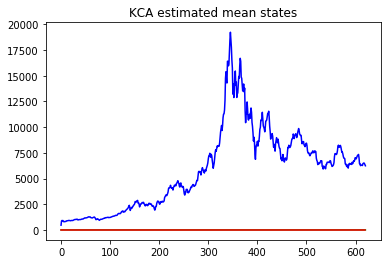

In [83]:
#measurements
#plt.scatter(df,y, df.weightedAverage)
#position
plt.plot(x_mean[:,0],color='blue') 
#velocity
plt.plot(x_mean[:,1],color='green') 
#acceleration
plt.plot(x_mean[:,2],color='red')
plt.title('KCA estimated mean states')

Text(0.5,1,'Velocity')

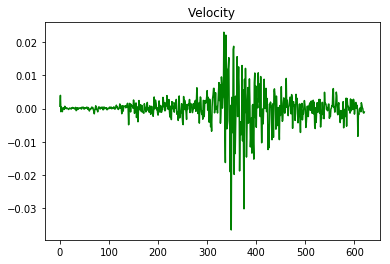

In [76]:
#velocity
plt.plot(x_mean[:,1],color='green') 
plt.title('Velocity')

Text(0.5,1,'Acceleration')

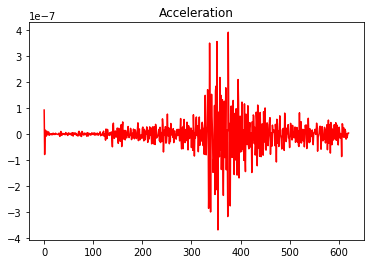

In [75]:
#acceleration
plt.plot(x_mean[:,2],color='red')
plt.title('Acceleration')

## Figure 2 (shows that FFT extracts a signal very similar to the first state component extracted by KCA) 